In [0]:
import glob
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, AveragePooling2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_train = pd.read_csv("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/train.csv", encoding="utf-8")
for i in df_train.columns[1:]:
  print(i)
  print(df_train[i].value_counts()[1])

healthy
516
multiple_diseases
91
rust
622
scab
592


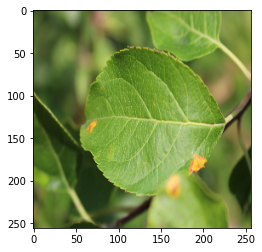

In [0]:
img_path = glob.glob("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/images/Train_*.jpg")
image = cv2.imread(img_path[0])
# image = image / 255
image = image[:,:,::-1]
image = cv2.resize(image, (256, 256))
plt.imshow(image)

In [0]:
IMG_SIZE = 224
# 資料處理 (處理train)
# img_path = glob.glob("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/images/Train_*.jpg")

x = []
y = []

img_path = "/content/drive/My Drive/Plant Pathology 2020 - FGVC7/images/"
with open("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/train.csv", "r", encoding="utf-8") as file:
  csvfile = csv.reader(file)
  next(csvfile)
  for i, row in tqdm(enumerate(csvfile)):
    img = cv2.imread(img_path + row[0]+".jpg")
    img = img[:,:,::-1] 
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32")

    # img = preprocess_input(img)
    x.append(img)
    y.append([row[1], row[2], row[3], row[4]])
x = np.array(x)
y = np.array(y, dtype=int)

print(x.shape)
print(y.shape)


(1821, 224, 224, 3)
(1821, 4)


In [0]:
x_test = []
with open("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/test.csv", "r", encoding="utf-8") as file:
  csvfile = csv.reader(file)
  next(csvfile)
  for i, row in tqdm(enumerate(csvfile)):
    img = cv2.imread(img_path + row[0]+".jpg")
    img = img / 255  #x_test的資料做normalize, x_train的資料會在ImageDataGenerator做normalize
    img = img[:,:,::-1] 
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32")
    # img = preprocess_input(img)
    x_test.append(img)
x_test = np.array(x_test)
print(x_test.shape)


(1821, 224, 224, 3)


In [0]:
# x, x_valid, y, y_valid = train_test_split(x, y, test_size=0.05, random_state=150)
# print(x.shape)
# print(y.shape)
# print(x_valid.shape)
# print(y_valid.shape)

(1729, 400, 400, 3)
(1729, 4)
(92, 400, 400, 3)
(92, 4)


In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.05, random_state=150)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(1729, 224, 224, 3)
(1729, 4)
(92, 224, 224, 3)
(92, 4)


In [0]:
datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True, 
    fill_mode = 'nearest',
    brightness_range=[0.5, 1.5]
)
datagen.fit(x)

In [0]:
x_valid = x_valid / 255.0

In [0]:
!pip install -U efficientnet

In [0]:
import efficientnet.tfkeras as efn
enet = efn.EfficientNetB6(weights='noisy-student', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in enet.layers:
  layer.trainable = True

In [0]:
X = GlobalAveragePooling2D()(enet.output)
X = Dense(4, activation="softmax")(X)
model = Model(inputs=enet.input, outputs=X)


model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [0]:
# healthy
# 516
# multiple_diseases
# 91
# rust
# 622
# scab
# 592
tf.keras.backend.clear_session()

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

optimizer = Adam(lr=3.0000e-04)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.fit(datagen.flow(x, y, batch_size=10),
          epochs=30,
          steps_per_epoch=y_train.shape[0] // 10,
          verbose=1, 
          # validation_data=(x_valid, y_valid),
          callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.3, patience=3, min_lr=0.000001)]
          # callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001),
          #            EarlyStopping(patience=10, restore_best_weights=True)]
          )



Epoch 1/30
172/172 [==============================] - 53s 309ms/step - loss: 0.1296 - accuracy: 0.9573 - lr: 3.0000e-04
Epoch 2/30
172/172 [==============================] - 53s 308ms/step - loss: 0.1201 - accuracy: 0.9614 - lr: 3.0000e-04
Epoch 3/30
172/172 [==============================] - 53s 308ms/step - loss: 0.1146 - accuracy: 0.9585 - lr: 3.0000e-04
Epoch 4/30
172/172 [==============================] - 53s 308ms/step - loss: 0.1195 - accuracy: 0.9614 - lr: 3.0000e-04
Epoch 5/30
172/172 [==============================] - 53s 309ms/step - loss: 0.0963 - accuracy: 0.9679 - lr: 3.0000e-04
Epoch 6/30
172/172 [==============================] - 53s 308ms/step - loss: 0.1223 - accuracy: 0.9614 - lr: 3.0000e-04
Epoch 7/30
172/172 [==============================] - 53s 309ms/step - loss: 0.1130 - accuracy: 0.9591 - lr: 3.0000e-04
Epoch 8/30
172/172 [==============================] - 53s 307ms/step - loss: 0.1196 - accuracy: 0.9638 - lr: 3.0000e-04
Epoch 9/30
172/172 [====================

In [0]:
from tensorflow.keras.utils import to_categorical

pre = model.predict(x_test)

pre_class = pre.argmax(axis=-1)

pre_cat = to_categorical(pre_class, dtype=int)

In [0]:
import pandas as pd
test_df = pd.read_csv("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/test.csv", encoding="utf-8")
test_label = test_df["image_id"]

result = pd.DataFrame({
        "image_id":test_label,
        "healthy":pre_cat[:, 0],
        "multiple_diseases":pre_cat[:, 1],
        "rust":pre_cat[:, 2],
        "scab":pre_cat[:, 3]
})

result.to_csv("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/efficientNet.csv", encoding="utf-8", index=False)

In [0]:
pre_valid = model.predict(x_valid)
pre_valid_class = pre_valid.argmax(axis=-1)
print(pre_valid_class)

[1 0 3 1 2 3 0 0 0 0 2 0 0 2 2 3 3 2 2 2 3 2 2 3 0 0 0 2 2 3 2 3 3 3 2 3 2
 3 0 2 0 0 3 0 0 0 3 3 2 3 3 2 0 3 1 3 2 2 3 0 2 2 2 2 0 2 2 0 2 0 3 2 0 2
 0 0 2 2 0 2 2 0 2 0 0 2 2 0 1 3 2 2]


In [0]:
y_valid_class = y_valid.argmax(axis=-1)
print(y_valid_class)

[1 0 3 1 2 3 0 0 0 0 2 0 0 2 2 3 3 2 2 2 3 2 2 3 0 0 0 2 2 3 2 3 3 3 2 3 2
 3 0 2 0 0 3 0 0 0 3 3 2 3 3 2 0 3 1 3 2 2 3 0 2 2 2 2 0 2 2 0 2 0 3 2 0 2
 0 0 2 2 0 2 2 0 2 0 0 2 2 0 1 3 2 2]


In [0]:
diff = np.nonzero(pre_valid_class != y_valid_class)[0]
print(diff)

[ 0  3 49 87 88]


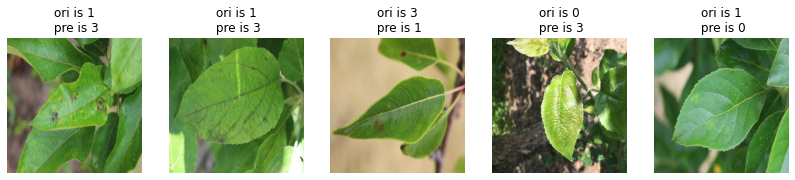

In [0]:
falseimg = x_valid[diff]
falselabel = pre_valid_class[diff]
truelabel = y_valid_class[diff]
width = 5
height = int(len(diff) / 5) + 1

plt.figure(figsize=(14, 70))

for i in range(len(diff)):
  plt.subplot(height, width, i+1)
  plt.title("ori is {}\n pre is {}".format(truelabel[i], falselabel[i]))
  plt.imshow(falseimg[i])
  plt.axis("off")

In [0]:
from tensorflow.keras.applications import InceptionResNetV2
IRV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [0]:
XX = GlobalAveragePooling2D()(IRV2.output)
XX = Dense(4, activation="softmax")(XX)
model_IRV2 = Model(inputs=IRV2.input, outputs=XX)
model_IRV2.summary()
                  

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [0]:
tf.keras.backend.clear_session()

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

optimizer = Adam(lr=2.7000e-05)
model_IRV2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model_IRV2.fit(datagen.flow(x, y, batch_size=10),
          epochs=10,
          steps_per_epoch=y.shape[0] // 10,
          verbose=1, 
          # validation_data=(x_valid, y_valid),
          callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.3, patience=3, min_lr=0.000001)]
          # callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001),
                    #  EarlyStopping(patience=10, restore_best_weights=True)]
          )



Epoch 1/10
182/182 [==============================] - 33s 180ms/step - loss: 0.0554 - accuracy: 0.9812 - lr: 2.7000e-05
Epoch 2/10
182/182 [==============================] - 33s 180ms/step - loss: 0.0507 - accuracy: 0.9862 - lr: 2.7000e-05
Epoch 3/10
182/182 [==============================] - 33s 180ms/step - loss: 0.0606 - accuracy: 0.9796 - lr: 2.7000e-05
Epoch 4/10
182/182 [==============================] - 33s 181ms/step - loss: 0.0623 - accuracy: 0.9796 - lr: 2.7000e-05
Epoch 5/10
182/182 [==============================] - 33s 182ms/step - loss: 0.0457 - accuracy: 0.9851 - lr: 2.7000e-05
Epoch 6/10
182/182 [==============================] - 33s 181ms/step - loss: 0.0570 - accuracy: 0.9823 - lr: 2.7000e-05
Epoch 7/10
182/182 [==============================] - 33s 181ms/step - loss: 0.0529 - accuracy: 0.9851 - lr: 2.7000e-05
Epoch 8/10
182/182 [==============================] - 33s 182ms/step - loss: 0.0474 - accuracy: 0.9840 - lr: 2.7000e-05
Epoch 9/10
182/182 [====================

In [0]:
from tensorflow.keras.utils import to_categorical

pre = model_IRV2.predict(x_test)

pre_class = pre.argmax(axis=-1)

pre_cat = to_categorical(pre_class, dtype=int)

In [0]:
import pandas as pd
test_df = pd.read_csv("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/test.csv", encoding="utf-8")
test_label = test_df["image_id"]

result = pd.DataFrame({
        "image_id":test_label,
        "healthy":pre_cat[:, 0],
        "multiple_diseases":pre_cat[:, 1],
        "rust":pre_cat[:, 2],
        "scab":pre_cat[:, 3]
})

result.to_csv("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/InceptionResNetV2.csv", encoding="utf-8", index=False)

In [0]:
from tensorflow.keras.utils import to_categorical

pre = model_IRV2.predict(x_test) + model.predict(x_test) / 2.0

pre_class = pre.argmax(axis=-1)

pre_cat = to_categorical(pre_class, dtype=int)

In [0]:
import pandas as pd
test_df = pd.read_csv("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/test.csv", encoding="utf-8")
test_label = test_df["image_id"]

result = pd.DataFrame({
        "image_id":test_label,
        "healthy":pre_cat[:, 0],
        "multiple_diseases":pre_cat[:, 1],
        "rust":pre_cat[:, 2],
        "scab":pre_cat[:, 3]
})

result.to_csv("/content/drive/My Drive/Plant Pathology 2020 - FGVC7/emsemble.csv", encoding="utf-8", index=False)